In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re
import nltk
import sys

sys.path.append('../')

%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
prefix = '/content/drive/My Drive/twitter_sentiment_analysis/'

In [9]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [0]:
from clean_helpers import *

take_full = True
test_locally = True

# Specify here what cleaning functions you want to use
cleaning_actions = ['clean_new_line', 'clean_tags', 'clean_punctuation', \
                    'remove_stopwords', 'remove_numbers', 'lemmatize']


clean = {
    "clean_new_line": clean_new_line,
    "lowercase": lowercase,
    "lemmatize": lemmatize,
    "remove_stopwords": remove_stopwords,
    "translate": perform_translation,
    "clean_punctuation": clean_punctuation,
    "clean_tags" : clean_tags,
    "remove_numbers": remove_numbers,
}

In [0]:
if take_full:
    input_file_pos = 'Data/train_pos_full.txt'
    input_file_neg = 'Data/train_neg_full.txt'
else:
    input_file_pos = 'Data/train_pos.txt'
    input_file_neg = 'Data/train_neg.txt'
    
input_file_test = 'Data/test_data.txt'

In [0]:
pos_sentences = []
with open(prefix + input_file_pos, 'r') as f:
    for sentence in f:
        pos_sentences.append(sentence)
        
neg_sentences = []
with open(prefix + input_file_neg, 'r') as f:
    for sentence in f:
        neg_sentences.append(sentence)

pos_data = pd.DataFrame(pos_sentences, columns=['sentence'])
pos_data['label'] = 1
neg_data = pd.DataFrame(neg_sentences, columns=['sentence'])
neg_data['label'] = -1

data = pd.concat([pos_data, neg_data])

In [0]:
for c in cleaning_actions:
    data = clean[c](data)

In [26]:
data

,sentence,label
0,dunno justin read mention justin god know hope...,1
1,logic dumb even crop name photo tsk,1
2,put casper box ! looved battle ! #crakkbitch,1
3,thanks sir trip lil mama .. keep doin ya thang !,1
4,visiting brother tmr bestest birthday gift eve...,1
...,...,...
1249995,im sorry ! & & u guy ridiculous ! >:/,-1
1249996,can't find food coloring anywhere,-1
1249997,! ! tort ! ! wonder chose crime module hahaa t...,-1
1249998,keyless entry remote fob clicker buick lacross...,-1


In [0]:
from collections import Counter

all_text_clean = ' '.join(list(data['sentence']))

# Create a list of words
words = all_text_clean.split()
# Count all the words using Counter Method
count_words = Counter(words)

total_words = len(words)
sorted_words = count_words.most_common(total_words)

vocab_to_int = {w:i for i, (w,c) in enumerate(sorted_words)}

In [0]:
encoded_sentences = []

for index, row in data.iterrows():
    encoded_sentence = [vocab_to_int[w] for w in row['sentence'].split()]
    encoded_sentences.append(encoded_sentence)

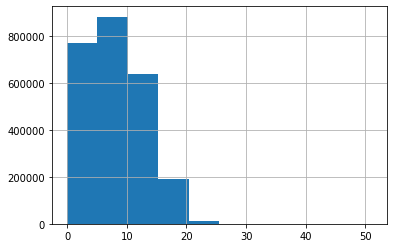

count    2.500000e+06
mean     8.582261e+00
std      4.578974e+00
min      0.000000e+00
25%      5.000000e+00
50%      8.000000e+00
75%      1.200000e+01
max      5.100000e+01
dtype: float64

In [29]:
sentences_lenghts = [len(x) for x in encoded_sentences]
max_sentence_lenght = np.max(sentences_lenghts)

pd.Series(sentences_lenghts).hist()
plt.show()
pd.Series(sentences_lenghts).describe()

In [0]:
X = pad_sequences(encoded_sentences, maxlen=max_sentence_lenght) 

In [31]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(len(vocab_to_int), embed_dim, mask_zero=True, input_length=max_sentence_lenght))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 51, 128)           71578496  
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 51, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 394       
Total params: 71,833,690
Trainable params: 71,833,690
Non-trainable params: 0
_________________________________________________________________
None


In [32]:
Y = pd.get_dummies(data['label']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(2250000, 51) (2250000, 2)
(250000, 51) (250000, 2)


In [0]:
batch_size = 128
model.fit(X_train, Y_train, epochs=5, batch_size=batch_size)
print()
#score,acc = model.evaluate(X_test, Y_test, verbose=2, batch_size=batch_size)
#print("score: %.2f" % (score))
#print("acc: %.2f" % (acc))
#print("\n\n")




Epoch 1/5





2250000/2250000 [==============================] - 2376s 1ms/step - loss: 0.3900 - acc: 0.8156
Epoch 2/5
2250000/2250000 [==============================] - 2342s 1ms/step - loss: 0.3421 - acc: 0.8441
Epoch 3/5
2250000/2250000 [==============================] - 2336s 1ms/step - loss: 0.3056 - acc: 0.8642
Epoch 4/5
2250000/2250000 [==============================] - 2332s 1ms/step - loss: 0.2828 - acc: 0.8743
Epoch 5/5
 741760/2250000 [========>.....................] - ETA: 26:02 - loss: 0.2653 - acc: 0.8822

In [0]:
validation_size = 10000

X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
X_test = X_test[:-validation_size]
Y_test = Y_test[:-validation_size]
score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

In [0]:
pos_cnt, neg_cnt, pos_correct, neg_correct = 0, 0, 0, 0
for x in range(len(X_validate)):
    
    result = model.predict(X_validate[x].reshape(1,X_test.shape[1]),batch_size=1,verbose = 2)[0]
   
    if np.argmax(result) == np.argmax(Y_validate[x]):
        if np.argmax(Y_validate[x]) == 0:
            neg_correct += 1
        else:
            pos_correct += 1
       
    if np.argmax(Y_validate[x]) == 0:
        neg_cnt += 1
    else:
        pos_cnt += 1



print("pos_acc", pos_correct/pos_cnt*100, "%")
print("neg_acc", neg_correct/neg_cnt*100, "%")

In [0]:
def prepare_test_data(list_of_sentences):    
    test_df = build_sentences(list_of_sentences, [])

    for clean_option in cleaning_options:
        test_df = clean[clean_option](test_df)
    
    enc_sentences = []

    for index, row in test_df.iterrows():
        enc_sentence = []
        
        for w in row['sentence'].split():
            try:
                enc_sentence.append(vocab_to_int[w])
            except:
                enc_sentence.append(0)
                
        enc_sentences.append(enc_sentence)
    
    lens = [len(x) for x in enc_sentences]
    max_len = np.max(lens)
    x_pred = sequence.pad_sequences(enc_sentences, maxlen=max_len) 
    return x_pred

In [0]:
test_sentences = []
with open(input_file_test, 'r') as f:
    for sentence in f:
        test_sentences.append(sentence)
        
X_pred = prepare_test_data(test_sentences)

In [0]:
result = model.predict(X_pred, batch_size=1, verbose = 2)[0]
